# Hotels Cancellations Prediction 
### Project goal
Predict whether a booking will be cancelled based on a list of features, and define the cancellation fee accordingly.

### Setup Libraries 

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Data 
Dataset source - https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand?resource=download

The hotel booking demand dataset is a comprehensive collection of information about hotel reservations, containing details from two types of hotels: a city hotel and a resort hotel. This dataset encompasses a wide range of variables related to bookings, including arrival dates, length of stay, number of guests, and other factors that can influence hotel demand and cancellations.

In [63]:
hotels = pd.read_csv("/Users/semergy/Downloads/hotel_bookings.csv")

In [64]:
hotels.head() 

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [65]:
hotels.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Defining the Target Variable (y): Hotel Reservation Status
Our prediction target, y, is the 'reservation_status' column. This variable represents the final status of each booking and has three possible outcomes:

- `Checked-Out`: The guest completed their stay as planned.
- `Canceled`: The reservation was canceled before the stay.
- `No-Show`: The guest did not arrive and did not cancel the reservation.

reservation_status
Check-Out    0.629584
Canceled     0.360307
No-Show      0.010110
Name: proportion, dtype: float64


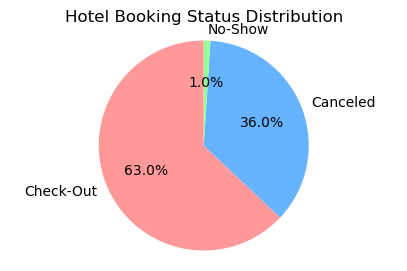

In [66]:
reservation_status_counts = hotels['reservation_status'].value_counts(1)
print(reservation_status_counts)

plt.figure(figsize=(5, 3))
plt.pie(reservation_status_counts.values, 
        labels=reservation_status_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=['#ff9999', '#66b3ff', '#99ff99'])  # Added a third color

# Add a title
plt.title('Hotel Booking Status Distribution', fontsize=12)
# Ensure the pie chart is drawn as a circle
plt.axis('equal')
# Display the chart
plt.show()

### Data Exploarion 
Early data exploration indicates that there's a higher cancellation rate in the summer months.

(0.0, 0.5)

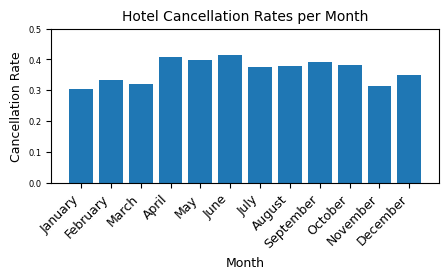

In [67]:
hotel_cancellation_per_month = hotels.groupby('arrival_date_month')['is_canceled'].mean()
# Sort the data by month
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
hotel_cancellation_per_month = hotel_cancellation_per_month.reindex(month_order)
# Create the bar plot
plt.figure(figsize=(5, 2))
bars = plt.bar(hotel_cancellation_per_month.index, hotel_cancellation_per_month.values)
# Customize the plot
plt.title('Hotel Cancellation Rates per Month', fontsize=10)
plt.xlabel('Month', fontsize=9)
plt.ylabel('Cancellation Rate', fontsize=9)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=6)
plt.ylim(0, 0.5)  # Set y-axis limit from 0 to 0.5 for better visualization

### Data Cleanup and Preperation

Removing the `is_canceled` column to prevent data leakage. This column directly indicates the reservation outcome, which is highly correlated with our target variable `reservation_status`. Including it would lead to an overfitted model that relies on information not available at the time of prediction, resulting in unreliable performance on new data.


In [68]:
hotels = hotels.drop(labels='is_canceled', axis=1)

To enhance model reliability and focus on relevant features, we'll remove columns with excessive missing values or those likely to introduce noise. We'll exclude the following columns:

- `agent` and `company`: Contain many missing values and may not generalize well.
- `arrival_date_day_of_month`, `arrival_date_year`, `arrival_date_week_number`: Redundant or too specific; we'll retain more general date information.
`country`: May lead to overfitting on geographical data that might not be predictive of cancellation behavior.

This process will help streamline our dataset and improve the model's ability to generalize to new bookings.

In [69]:
irrelevant_colls = ['agent', 'company', 'reservation_status_date', 'arrival_date_day_of_month', 'arrival_date_year', 'arrival_date_week_number', 'country']
hotels = hotels.drop(labels=irrelevant_colls, axis=1)

To prepare our dataset for model training, we need to convert categorical variables into a numerical format. We'll use one-hot encoding for columns with nominal categorical data, such as `deposit_type`. This process creates binary columns for each category, allowing the model to effectively use this information without implying any ordinal relationship between categories.

In [70]:
categorial_data = ['distribution_channel', 'hotel', 'meal', 'market_segment', 'assigned_room_type', 'reserved_room_type', 'arrival_date_month', 'deposit_type', 'customer_type']
hotels = pd.get_dummies(hotels, columns=categorial_data, dtype = int)

hotels.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,342,0,0,2,0.0,0,0,0,0,3,...,0,0,0,1,0,0,0,0,1,0
1,737,0,0,2,0.0,0,0,0,0,4,...,0,0,0,1,0,0,0,0,1,0
2,7,0,1,1,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,13,0,1,1,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,14,0,2,2,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


Encode the reservation_status column using label encoding instead of one-hot encoding. I chose this method because we need to maintain all values in a single column rather than creating separate binary columns. Label encoding assigns a unique integer to each category, preserving the column's structure while converting it to a numerical format suitable for model training. This approach is appropriate when we want to keep the target variable as a single column for certain types of models or analyses.

In [71]:
hotels['reservation_status'] = hotels['reservation_status'].replace({'Check-Out':2, 'Canceled':1, 'No-Show':0})

### Preparing Features (X) and Target (y) for Model Training 

To prepare our data for model training and evaluation, we need to separate our features (predictors) from our target variable:

- Features (`X`): We'll create a list of all columns except `reservation_status`. These features will be used to predict the booking outcome.
- Target (`y`): We'll use the `reservation_status` column as our target variable, which we aim to predict.

This separation allows us to train our model on the features while using the target variable to evaluate its performance.

In [72]:
x_features = hotels.drop(['reservation_status'], axis=1)

Before training our model, it's crucial to address any missing values in our dataset. We'll identify and remove columns containing NaN (Not a Number) values:

1. <b>Identify columns with NaN values</b>: We scan all feature columns to find those containing any missing data.
2. <b>Remove affected columns</b>: Rather than imputing values, we opt to remove entire columns with missing data to ensure data integrity.
3. <b>Document removed columns</b>: We keep track of which columns are removed, providing transparency in our data preprocessing steps.

In [74]:
nan_columns = x_features.columns[x_features.isna().any()]
x_features = x_features.drop(columns=nan_columns)
print("Columns removed due to NaN values:", nan_columns.tolist())

# Cleanup: Remove zero-variance columns
#zero_var_columns = x_features.columns[x_features.std() == 0]
#x_features = x_features.drop(columns=zero_var_columns)
#print("Columns removed due to zero variance:", zero_var_columns.tolist())

#print("X shape after cleaning:", x_features.shape)

Columns removed due to NaN values: ['children']


After handling missing values, it's essential to ensure that our features are in the correct format for model training. Our goal is to confirm that all remaining features are either integers (int) or floating-point numbers (float). 

In [76]:
x_features.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 74 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       119390 non-null  int64  
 1   stays_in_weekend_nights         119390 non-null  int64  
 2   stays_in_week_nights            119390 non-null  int64  
 3   adults                          119390 non-null  int64  
 4   babies                          119390 non-null  int64  
 5   is_repeated_guest               119390 non-null  int64  
 6   previous_cancellations          119390 non-null  int64  
 7   previous_bookings_not_canceled  119390 non-null  int64  
 8   booking_changes                 119390 non-null  int64  
 9   days_in_waiting_list            119390 non-null  int64  
 10  adr                             119390 non-null  float64
 11  required_car_parking_spaces     119390 non-null  int64  
 12  total_of_special

## Create x and y tensors

Import the following PyTorch modules for our neural network model:

- `torch`: Core PyTorch functionality
- `torch.nn`: Neural network layers and components
- `torch.optim`: Optimization algorithms for model training

In [14]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim

Converting Features and Target to PyTorch Tensors
We convert our feature matrix (X) and target variable (y) to PyTorch tensors:

- `X`: Convert features to float32 tensor for model input
- `y`: Convert target to long tensor for classification labels

This transformation prepares our data for use with PyTorch models, ensuring compatibility and efficient computation.

In [78]:
X = torch.tensor(x_features.values, dtype=torch.float32)
y = torch.tensor(hotels['reservation_status'].values, dtype=torch.long)

### Split the data to test and train 

We divide our dataset into training and test sets:
- Train the model on a majority of the data (80%)
- Reserve a portion (20%) for testing the model's performance

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 12)

print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

Training Shape: torch.Size([95512, 74])
Testing Shape: torch.Size([23878, 74])


In [80]:
#nan_columns = torch.isnan(X_train).any(dim=0)
#print("Columns with NaN:", nan_columns.nonzero().squeeze())

### Defining the Neural Network Architecture

We create a feedforward neural network for our hotel cancellation prediction task:
1. <B>Input layer</b>: Accepts 74 features
2. <B>First hidden layer</b>: 74 neurons with ReLU activation
3. <B>Second hidden layer</b>: 36 neurons with ReLU activation
4. <B>Output layer</b>: 3 neurons (one for each possible reservation status)

In [86]:
torch.manual_seed(12)

neural_net = nn.Sequential(
    nn.Linear(74, 74),
    nn.ReLU(),
    nn.Linear(74, 36),
    nn.ReLU(),
    nn.Linear(36, 3)
)

### Defining the Loss Function
We use Cross-Entropy Loss for our model. This function quantifies the difference between our model's predictions and the actual reservation statuses, providing a measure of our model's performance during training.

In [88]:
loss = nn.CrossEntropyLoss()

### Defining the Loss Function
We use the Adam optimizer for training our neural network. Adam adapts the learning rate for each parameter, which can lead to faster convergence and better performance, especially for problems with sparse gradients or noisy data.

In [89]:
optimizer = optim.Adam(neural_net.parameters(), lr=0.01)

### Training the Neural Network!

Training the Neural Network
We implement a training loop to optimize our model:

1. Set the number of epochs (500)
2. For each epoch:
- Generate predictions
- Calculate loss
- Perform backpropagation
- Update model parameters
3. Every 100 epochs:
- Compute and display training accuracy
- Print progress (epoch number, loss, accuracy)

This process iteratively improves our model's ability to predict hotel reservation statuses, allowing us to monitor its performance throughout training.

In [90]:
from sklearn.metrics import accuracy_score

num_epochs = 500
for epoch in range(num_epochs):
    predictions = neural_net(X_train)
    CELoss = loss(predictions, y_train)
    CELoss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch + 1) % 100 == 0:
        predicted_labels = torch.argmax(predictions, dim=1)
        accuracy = accuracy_score(y_train, predicted_labels)
        print(f'Epoch [{epoch+1}/{num_epochs}], CELoss: {CELoss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch [100/500], CELoss: 0.3836, Accuracy: 0.8358
Epoch [200/500], CELoss: 0.3562, Accuracy: 0.8492
Epoch [300/500], CELoss: 0.3485, Accuracy: 0.8501
Epoch [400/500], CELoss: 0.3401, Accuracy: 0.8552
Epoch [500/500], CELoss: 0.3326, Accuracy: 0.8580


## Evaluating the Model
After training, we use our model to make predictions on the test set.

In [93]:
neural_net.eval()
with torch.no_grad():
    neural_net_predictions = neural_net(X_test)
    neural_nets_predicted_labels = torch.argmax(neural_net_predictions, dim=1)

We calculate and display the model's performance metrics on the test set. This includes overall accuracy and a detailed classification report. These metrics provide insights into how well our neural network predicts each class of hotel reservation status, helping us assess its effectiveness and identify any areas for improvement.

In [94]:
from sklearn.metrics import accuracy_score, classification_report

neural_net_accuracy = accuracy_score(y_test, neural_nets_predicted_labels)
print(f'Accuracy: {neural_net_accuracy.item():.4f}')

neural_net_report = classification_report(y_test, neural_nets_predicted_labels)
print("Classification Report:\n", neural_net_report)

Accuracy: 0.8384
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.02      0.04       241
           1       0.83      0.73      0.78      8711
           2       0.84      0.91      0.88     14926

    accuracy                           0.84     23878
   macro avg       0.89      0.56      0.57     23878
weighted avg       0.84      0.84      0.83     23878



### Summary of Model Performance

Our neural network achieved an overall accuracy of 83.84% on the test set. Breaking down the performance:

1. <b>Strong performance</b> on 'Checked-Out' and 'Canceled' reservations.
2. <b>Poor recall</b> for 'No-Show' reservations, despite high precision.

Importantly, we previously observed that only 1% of our data represents 'No-Show' cases. This severe class imbalance explains the model's struggle with this category. The low performance on 'No-Show' cases is likely due to insufficient representation in the training data.
This imbalance presents a challenge in accurately predicting rare events, highlighting the need for strategies to address class imbalance in future iterations of the model.

## Calculate Cancellation Fee 
### Define the Cancellation Fee Calculator Function
We should define our main function that calculates the cancellation fee based on the model's output and the booking price. This function implements the tiered fee structure we discussed earlier.

In [100]:
def predict_and_calculate_fee(features, booking_price, model, scaler, expected_features=74):
    # Handle missing or empty features
    processed_features = []
    for feature in features:
        if feature is None or feature == '':
            processed_features.append(0)  # Replace missing values with 0
        else:
            processed_features.append(float(feature))
    
    # Ensure we have the expected number of features
    if len(processed_features) < expected_features:
        processed_features.extend([0] * (expected_features - len(processed_features)))
    elif len(processed_features) > expected_features:
        processed_features = processed_features[:expected_features]
    
    # Convert to numpy array and reshape
    features_array = np.array(processed_features).reshape(1, -1)
    
    # Scale features
    scaled_features = torch.tensor(scaler.transform(features_array), dtype=torch.float32)
    
    # Get model prediction
    model.eval()
    with torch.no_grad():
        output = model(scaled_features)
        probabilities = torch.softmax(output, dim=1)
    
    # Extract cancellation probability (assuming 'Canceled' is index 1)
    cancel_prob = probabilities[0, 1].item()
    
    # Calculate fee
    if cancel_prob <= 0.25:
        fee = booking_price * 0.10
    elif cancel_prob <= 0.50:
        fee = booking_price * 0.25
    elif cancel_prob <= 0.75:
        fee = booking_price * 0.50
    else:
        fee = booking_price * 0.75
    
    return cancel_prob, fee

### Test the function with complete data  

In [102]:
# Test case for a hypothetical hotel reservation
test_reservation = [
    30,     # lead_time (30 days)
    2,      # stays_in_weekend_nights
    3,      # stays_in_week_nights
    2,      # adults
    0,      # babies
    0,      # is_repeated_guest (0 for No, 1 for Yes)
    0,      # previous_cancellations
    0,      # previous_bookings_not_canceled
    1,      # booking_changes
    0,      # days_in_waiting_list
    150.0,  # adr (average daily rate)
    0,      # required_car_parking_spaces
    1,      # total_of_special_requests
    0, 1, 0, 0, 0,  # distribution_channel (Direct)
    1, 0,  # hotel (City Hotel)
    1, 0, 0, 0, 0,  # meal (BB - Bed & Breakfast)
    0, 0, 0, 1, 0, 0, 0, 0,  # market_segment (Direct)
    1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # assigned_room_type (A)
    1, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # reserved_room_type (A)
    0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,  # arrival_date_month (July)
    1, 0, 0,  # deposit_type (No Deposit)
    0, 0, 1, 0  # customer_type (Transient)
]

# Booking price (can be different from adr * number of nights if there are discounts or fees)
test_booking_price = 750.0

# Now you can use this test case with your prediction and fee calculation function
cancel_prob, fee = predict_and_calculate_fee(test_reservation, test_booking_price, neural_net, scaler)

print(f"Cancellation Probability: {cancel_prob:.2f}")
print(f"Calculated Fee: ${fee:.2f}")

Cancellation Probability: 0.06
Calculated Fee: $75.00


### Test the function with partial data 

In [104]:
# Example usage with missing features
incomplete_reservation = [30, 2, 3, 2, None, '', 0, 0, 1]  # Only 9 features provided
booking_price = 750.0

try:
    cancel_prob, fee = predict_and_calculate_fee(incomplete_reservation, booking_price, neural_net, scaler)
    print(f"Cancellation Probability: {cancel_prob:.2f}")
    print(f"Calculated Fee: ${fee:.2f}")
except Exception as e:
    print(f"An error occurred: {e}")

Cancellation Probability: 0.21
Calculated Fee: $75.00
